In [1]:
# note some canopy heights are deffo wrong - 94m???

In [2]:
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import cartopy.crs as ccrs
import cartopy.crs as crs
import cartopy.feature as cfeature
import h5py  
from astropy.time import Time
import os
import glob
from osgeo import gdal
import scipy.ndimage
import rasterio as rio
import re
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
from pyhdf.SD import SD, SDC
import pprint
import csv

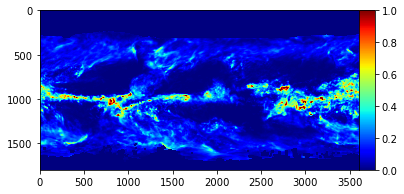

In [3]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\rainfall"   # I should change this so I can work from github?
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)
    
# select first MODIS file
IMERGFiles = glob.glob('*IMERG*')
IMERG = h5py.File(IMERGFiles[8], 'r')

precipitation = IMERG['/Grid/precipitation/'][:]
precipitation = np.transpose(precipitation)
latitude = IMERG['/Grid/lat'] [:]
longitude = IMERG['/Grid/lon'][::]

fig, axes = plt.subplots() 
img = axes.imshow(precipitation, vmin =0,vmax = 1, cmap = "jet")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")
color_bar = plt.colorbar(img, cax = cax) 

Convert ATL08 data

In [4]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\ATL08"   # I should change this so I can work from github?
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [5]:
# constants for conversion lat lon -> tile H,V and r,c
R = 6371007.181	    # the radius of the idealizes sphere representing the Earth
T = 1111950	        # the height and width of each MODIS tile in the projection plane
Xmin = -20015109    # the western limit of the projection plane
Ymax = 10007555	    # the northern limit of the projection plane
w = T/2400.0	    # the actual size of a '500m' MODIS sinusoidal grid cell. (would be /1200 for a 1km grid)

In [6]:
all_points = pd.read_csv("D:\\masters_data\\output\\csv\\all_points.csv", header=None)

In [7]:
all_points.columns= ["latitude", "longitude", "mean_canopy", "max_canopy", "min_canopy", "median_canopy", "canopy_openness" ]

In [8]:
latitude = all_points['latitude'][:]
longitude = all_points['longitude'][:]
mean_height = all_points["mean_canopy"][:]
max_height = all_points["max_canopy"][:]
min_height = all_points["min_canopy"][:]
median_canopy = all_points["median_canopy"][:]
canopy_openness = all_points["canopy_openness"][:]

In [9]:
string_latitude = latitude.to_string(index = False)
string_latitude = latitude.replace("\n", ",")

string_longitude = longitude.to_string(index = False)
string_longitude = longitude.replace("\n", ",")

string_mean_height = mean_height.to_string(index = False)
string_mean_height = mean_height.replace("\n", ",")

string_max_height = max_height.to_string(index = False)
string_max_height = max_height.replace("\n", ",")

string_min_height = min_height.to_string(index = False)
string_min_height = min_height.replace("\n", ",")

string_median_canopy = median_canopy.to_string(index = False)
string_median_canopy = median_canopy.replace("\n", ",")

string_canopy_openness = canopy_openness.to_string(index = False)
string_canopy_openness = canopy_openness.replace("\n", ",")

In [10]:
float_latitude = [float(i) for i in string_latitude]
float_longitude = [float(i) for i in string_longitude]
float_mean_height = [float(i) for i in string_mean_height]
float_max_height = [float(i) for i in string_max_height]
float_min_height = [float(i) for i in string_min_height]
float_median_canopy = [float(i) for i in string_median_canopy]
float_canopy_openness = [float(i) for i in string_canopy_openness]

In [11]:
canopy_height_array = np.zeros((2400,2400))
canopy_max_height_array = np.zeros((2400,2400))
canopy_min_height_array = np.zeros((2400,2400))
canopy_median_height_array = np.zeros((2400,2400))
canopy_openness_array = np.zeros((2400,2400))

In [12]:
number = 0
r_list = []
c_list = []
    
for i in latitude:
    lat = float_latitude[number]
    lon = float_longitude[number]
    phi = lat/(180/math.pi) # convert to radians
    lamb = lon/(180/math.pi)
    x = R*lamb*math.cos(phi)
    y = R*phi
    r = int(math.floor(((Ymax-y)%T)/w-0.5))
    c = int(math.floor(((x-Xmin)%T)/w-0.5))
    
    r_list.append(r)
    c_list.append(c)
    number += 1

In [13]:
for ii in range(len(r_list)):
    row = r_list[ii]
    col = c_list[ii]
    canopy_height_array[row, col] = float_mean_height[ii]
    canopy_max_height_array[row, col] = float_mean_height[ii]
    canopy_min_height_array[row, col] = float_mean_height[ii]
    canopy_median_height_array[row, col] = float_mean_height[ii]
    canopy_openness_array[row, col] = float_mean_height[ii]

In [14]:
np.savetxt("D:\\masters_data\\output\\csv\\total_canopy_height_array_(meancanopyfile).csv", canopy_height_array, delimiter=",")
np.savetxt("D:\\masters_data\\output\\csv\\canopy_max_height_array(meancanopyfile).csv", canopy_max_height_array, delimiter=",")
np.savetxt("D:\\masters_data\\output\\csv\\canopy_min_height_array(meancanopyfile).csv", canopy_min_height_array, delimiter=",")
np.savetxt("D:\\masters_data\\output\\csv\\canopy_median_height_array(meancanopyfile).csv", canopy_median_height_array, delimiter=",")
np.savetxt("D:\\masters_data\\output\\csv\\canopy_openness_array(meancanopyfile).csv", canopy_openness_array, delimiter=",")

# now need to create the different categories for analysis

In [15]:
# need to exclude 0 values from analysis

In [16]:
First_BA = pd.read_csv("D:\\masters_data\\output\\first_BA.csv", header=None)
Second_BA = pd.read_csv("D:\\masters_data\\output\\second_BA.csv", header=None)

In [17]:
Mask = np.zeros((2400, 2400))
# low_low / low_med / low_high

Mask[((First_BA<1) * (Second_BA<1))==1] = 1
Mask[((First_BA<1) * (Second_BA>=1) * (Second_BA<7))==1] = 2
Mask[((First_BA<1) * (Second_BA>=7))==1] = 3

# med_low / med_med / med_high
Mask[((First_BA>=1) * (First_BA<7) * (Second_BA<1))==1] = 4
Mask[((First_BA>=1) * (First_BA<7) * (Second_BA>=1) * (Second_BA<7))==1] = 5
Mask[((First_BA>=1) * (First_BA<7) * (Second_BA>=7))==1] = 6

#high_low / high_med / high_high
Mask[((Second_BA<1) * (First_BA>=7))==1] = 7
Mask[((First_BA>=7) * (Second_BA>=1) * (Second_BA<7))==1] = 8
Mask[((First_BA>=7) * (Second_BA>=7))==1] = 9

# this takes out where canopy height == 0, but means that the colormaps are hardly visible
# Mask[(canopy_height_array==0)==1]=0

In [18]:
low_low = np.zeros((2400, 2400))
low_med = np.zeros((2400, 2400))
low_high = np.zeros((2400, 2400))

med_low = np.zeros((2400, 2400))
med_med = np.zeros((2400, 2400))
med_high = np.zeros((2400, 2400))

high_low = np.zeros((2400, 2400))
high_med = np.zeros((2400, 2400))
high_high = np.zeros((2400, 2400))

In [19]:
low_low[Mask==1] = 1
low_med[Mask==2] = 1
low_high[Mask==3] = 1

med_low[Mask==4] = 1
med_med[Mask==5] = 1
med_high[Mask==6] = 1

high_low[Mask==7] = 1
high_med[Mask==8] = 1
high_high[Mask==9] = 1

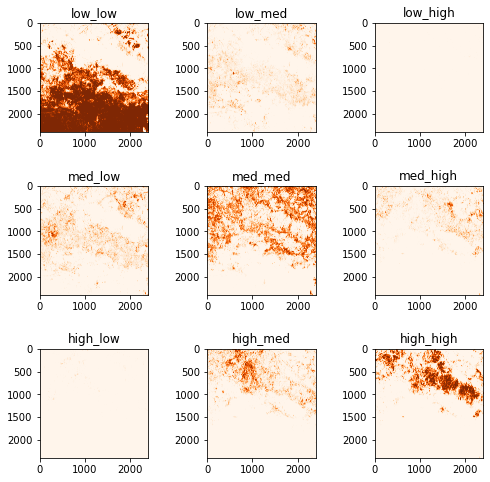

In [20]:
f, axs = plt.subplots(3,3,figsize=(8,8))

# low_low
plt.subplot(3,3,1)
color_map = plt.imshow(low_low)
plt.title("low_low")
img = axes.imshow(low_low, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# low_med
plt.subplot(3,3,2)
color_map = plt.imshow(low_med)
plt.title("low_med")
img = axes.imshow(low_med, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# low_high
plt.subplot(3,3,3)
color_map = plt.imshow(low_high)
plt.title("low_high")
img = axes.imshow(low_high, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# med_low
plt.subplot(3,3,4)
color_map = plt.imshow(med_low)
plt.title("med_low")
img = axes.imshow(med_low, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# med_med
plt.subplot(3,3,5)
color_map = plt.imshow(med_med)
plt.title("med_med")
img = axes.imshow(med_med, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# med_high
plt.subplot(3,3,6)
color_map = plt.imshow(med_high)
plt.title("med_high")
img = axes.imshow(med_high, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# high_low
plt.subplot(3,3,7)
color_map = plt.imshow(high_low)
plt.title("high_low")
img = axes.imshow(high_low, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# high_med
plt.subplot(3,3,8)
color_map = plt.imshow(high_med)
plt.title("high_med")
img = axes.imshow(high_med, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# high_high
plt.subplot(3,3,9)
color_map = plt.imshow(high_high)
plt.title("high_high")
img = axes.imshow(high_high, vmin = 0, vmax = 1, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

plt.subplots_adjust(wspace= 0.5, hspace = 0.5)
plt.show()

In [21]:
first_mask = np.zeros((2400, 2400))
second_mask = np.zeros((2400, 2400))

# first_low / first_med / first_high
first_mask[(First_BA<=1)==1] = 1
first_mask[((First_BA>=1) * (First_BA<7))==1] = 2
first_mask[(First_BA>7) ==1] = 3

# second_low / second_med / second_high
second_mask[(Second_BA<=1)==1] = 1
second_mask[((Second_BA>=1) * (First_BA<7))==1] = 2
second_mask[(Second_BA>7) ==1] = 3

# first_mask[(canopy_height_array==0)==1]=0
# second_mask[(canopy_height_array==0)==1]=0

In [22]:
first_low = np.zeros((2400, 2400))
first_med = np.zeros((2400, 2400))
first_high = np.zeros((2400, 2400))

second_low = np.zeros((2400, 2400))
second_med = np.zeros((2400, 2400))
second_high = np.zeros((2400, 2400))

In [23]:
first_low[first_mask==1] = 1
first_med[first_mask==2] = 1
first_high[first_mask==3] = 1

second_low[second_mask==1] = 1
second_med[second_mask==2] = 1
second_high[second_mask==3] = 1

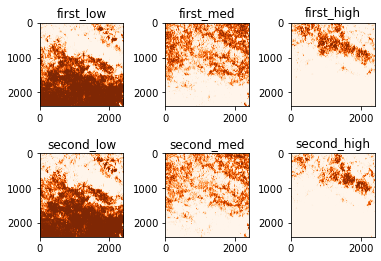

In [24]:
# first_low
plt.subplot(2,3,1)
color_map = plt.imshow(first_low)
plt.title("first_low")
img = axes.imshow(first_low, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# first_med
plt.subplot(2,3,2)
color_map = plt.imshow(first_med)
plt.title("first_med")
img = axes.imshow(first_med, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# first_high
plt.subplot(2,3,3)
color_map = plt.imshow(first_high)
plt.title("first_high")
img = axes.imshow(first_high, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# second_low
plt.subplot(2,3,4)
color_map = plt.imshow(second_low)
plt.title("second_low")
img = axes.imshow(second_low, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# second_med
plt.subplot(2,3,5)
color_map = plt.imshow(second_med)
plt.title("second_med")
img = axes.imshow(second_med, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")

# second_high
plt.subplot(2,3,6)
color_map = plt.imshow(second_high)
plt.title("second_high")
img = axes.imshow(second_high, vmin = 0, vmax = 15, cmap = "Oranges")
plt.colorbar(img, cax = cax)
color_map.set_cmap("Oranges")
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")
fig.subplots_adjust(right=0.8)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)

plt.subplots_adjust(wspace= 0.5, hspace = 0.5)
plt.show()

shows what we would expect - unfortunately there isn't much of an overlap
Need to do this for NDVI
Need to count low_low etc


In [25]:
#redone without where canopy=0

Mask_nocanopy = np.zeros((2400, 2400))
# low_low / low_med / low_high

Mask_nocanopy[((First_BA<1) * (Second_BA<1))==1] = 1
Mask_nocanopy[((First_BA<1) * (Second_BA>=1) * (Second_BA<7))==1] = 2
Mask_nocanopy[((First_BA<1) * (Second_BA>=7))==1] = 3

# med_low / med_med / med_high
Mask_nocanopy[((First_BA>=1) * (First_BA<7) * (Second_BA<1))==1] = 4
Mask_nocanopy[((First_BA>=1) * (First_BA<7) * (Second_BA>=1) * (Second_BA<7))==1] = 5
Mask_nocanopy[((First_BA>=1) * (First_BA<7) * (Second_BA>=7))==1] = 6

#high_low / high_med / high_high
Mask_nocanopy[((Second_BA<1) * (First_BA>=7))==1] = 7
Mask_nocanopy[((First_BA>=7) * (Second_BA>=1) * (Second_BA<7))==1] = 8
Mask_nocanopy[((First_BA>=7) * (Second_BA>=7))==1] = 9

# this takes out where canopy height == 0, but means that the colormaps are hardly visible
Mask_nocanopy[(canopy_height_array==0)==1]=0

In [26]:
print("Number of pixels in each category")
print()
print("\t\t W canopy=0 \t w/o canopy=0 ")
print("Low-low:\t {0}\t {1}".format(np.count_nonzero(Mask == 1),np.count_nonzero(Mask_nocanopy == 1)))
print("Low-med:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 2),np.count_nonzero(Mask_nocanopy == 2)))
print("Low-high:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 3),np.count_nonzero(Mask_nocanopy == 3)))
print("med-low:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 4),np.count_nonzero(Mask_nocanopy == 4)))
print("med-med:\t {0}\t {1}".format(np.count_nonzero(Mask == 5),np.count_nonzero(Mask_nocanopy == 5)))
print("med-med:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 6),np.count_nonzero(Mask_nocanopy == 6)))
print("high-low:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 7),np.count_nonzero(Mask_nocanopy == 7)))
print("high-med:\t {0}\t\t {1}".format(np.count_nonzero(Mask == 8),np.count_nonzero(Mask_nocanopy == 8)))
print("high-high\t {0}\t\t {1}".format(np.count_nonzero(Mask == 9),np.count_nonzero(Mask_nocanopy == 9)))

Number of pixels in each category

		 W canopy=0 	 w/o canopy=0 
Low-low:	 2780864	 97194
Low-med:	 245663		 10990
Low-high:	 473		 26
med-low:	 393200		 20208
med-med:	 1073281	 62186
med-med:	 188463		 12599
high-low:	 5075		 320
high-med:	 383247		 26283
high-high	 689734		 50943


Now I want to calculate the mean tree canopy height (for w/o canopy=0)

In [27]:
low_low_canopy = np.zeros((2400, 2400))
low_low_canopy[low_low_canopy ==0] = np.nan

low_med_canopy = np.zeros((2400, 2400))
low_med_canopy[low_med_canopy ==0] = np.nan

low_high_canopy = np.zeros((2400, 2400))
low_high_canopy[low_high_canopy ==0] = np.nan

med_low_canopy = np.zeros((2400, 2400))
med_low_canopy[med_low_canopy ==0] = np.nan

med_med_canopy = np.zeros((2400, 2400))
med_med_canopy[med_med_canopy ==0] = np.nan

med_high_canopy = np.zeros((2400, 2400))
med_high_canopy[med_high_canopy ==0] = np.nan

high_low_canopy = np.zeros((2400, 2400))
high_low_canopy[high_low_canopy ==0] = np.nan

high_med_canopy = np.zeros((2400, 2400))
high_med_canopy[high_med_canopy ==0] = np.nan

high_high_canopy = np.zeros((2400, 2400))
high_high_canopy[high_high_canopy ==0] = np.nan

In [28]:
low_low_canopy[Mask_nocanopy == 1] = canopy_height_array[Mask_nocanopy == 1]
low_med_canopy[Mask_nocanopy == 2] = canopy_height_array[Mask_nocanopy == 2]
low_high_canopy[Mask_nocanopy == 3] = canopy_height_array[Mask_nocanopy == 3]

med_low_canopy[Mask_nocanopy == 4] = canopy_height_array[Mask_nocanopy == 4]
med_med_canopy[Mask_nocanopy == 5] = canopy_height_array[Mask_nocanopy == 5]
med_high_canopy[Mask_nocanopy == 6] = canopy_height_array[Mask_nocanopy == 6]

high_low_canopy[Mask_nocanopy == 7] = canopy_height_array[Mask_nocanopy == 7]
high_med_canopy[Mask_nocanopy == 8] = canopy_height_array[Mask_nocanopy == 8]
high_high_canopy[Mask_nocanopy == 9] = canopy_height_array[Mask_nocanopy == 9]

In [29]:
print("Number of pixels in each category")
print()
print("\t\t All land types  only savannah \t mean canopy")
print("Low-low:\t {0}\t {1}\t\t {2}".format(np.count_nonzero(Mask == 1),np.count_nonzero(Mask_nocanopy == 1), round(np.nanmean(low_low_canopy), 4)))
print("Low-med:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 2),np.count_nonzero(Mask_nocanopy == 2), round(np.nanmean(low_med_canopy), 4)))
print("Low-high:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 3),np.count_nonzero(Mask_nocanopy == 3), round(np.nanmean(low_high_canopy),4 )))
print("med-low:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 4),np.count_nonzero(Mask_nocanopy == 4), round(np.nanmean(med_low_canopy), 4)))
print("med-med:\t {0}\t {1}\t\t {2}".format(np.count_nonzero(Mask == 5),np.count_nonzero(Mask_nocanopy == 5), round(np.nanmean(med_med_canopy), 4)))
print("med-high:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 6),np.count_nonzero(Mask_nocanopy == 6), round(np.nanmean(med_high_canopy), 4)))
print("high-low:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 7),np.count_nonzero(Mask_nocanopy == 7), round(np.nanmean(high_low_canopy), 4)))
print("high-med:\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 8),np.count_nonzero(Mask_nocanopy == 8), round(np.nanmean(high_med_canopy), 4)))
print("high-high\t {0}\t\t {1}\t\t {2}".format(np.count_nonzero(Mask == 9),np.count_nonzero(Mask_nocanopy == 9), round(np.nanmean(high_high_canopy),4)))

print()
decrease_ff = (np.count_nonzero(Mask == 4) + np.count_nonzero(Mask == 7) + np.count_nonzero(Mask == 8))
constant_ff = (np.count_nonzero(Mask == 1) + np.count_nonzero(Mask == 5) + np.count_nonzero(Mask == 9))
increase_ff = (np.count_nonzero(Mask == 2) + np.count_nonzero(Mask == 3) + np.count_nonzero(Mask == 6))
print("Total decrease: {}".format(decrease_ff))
print("Total constant: {}".format(constant_ff))
print("total increase: {}".format(increase_ff))

Number of pixels in each category

		 All land types  only savannah 	 mean canopy
Low-low:	 2780864	 97194		 10.8805
Low-med:	 245663		 10990		 8.4789
Low-high:	 473		 26		 6.4169
med-low:	 393200		 20208		 7.9386
med-med:	 1073281	 62186		 6.7618
med-high:	 188463		 12599		 6.4384
high-low:	 5075		 320		 6.7761
high-med:	 383247		 26283		 6.3464
high-high	 689734		 50943		 6.2719

Total decrease: 781522
Total constant: 4543879
total increase: 434599


In [30]:
decrease = round(((np.nanmean(med_low_canopy) + np.nanmean(high_low_canopy) + np.nanmean(high_med_canopy)) / 3), 4)
constant = round(((np.nanmean(low_low_canopy) + np.nanmean(med_med_canopy) + np.nanmean(high_high_canopy)) / 3), 4)
increase = round(((np.nanmean(low_med_canopy) + np.nanmean(low_high_canopy) + np.nanmean(med_high_canopy)) / 3), 4)

In [31]:
change_mask = np.zeros((2400, 2400))

# decrease
change_mask[Mask == 4] = 1
change_mask[Mask == 7] = 1
change_mask[Mask == 8] = 1

# no change
change_mask[Mask == 1] = 2
change_mask[Mask == 5] = 2
change_mask[Mask == 9] = 2

# no change
change_mask[Mask == 2] = 3
change_mask[Mask == 3] = 3
change_mask[Mask == 6] = 3

In [32]:
change_cmap = colors.ListedColormap(["blue", "gainsboro", "red"])

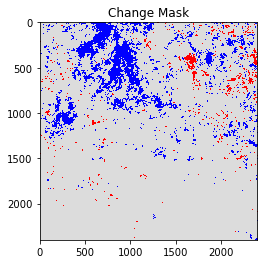

<Figure size 3200x3200 with 0 Axes>

In [33]:
color_map = plt.imshow(change_mask)
plt.title("Change Mask")
img = axes.imshow(change_mask, cmap = change_cmap)
plt.colorbar(img, cax = cax)
color_map.set_cmap(change_cmap)
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %")
color_bar = plt.colorbar(img, cax = cax) 
plt.figure(figsize= (32,32), dpi=100)
plt.show()

## Bring in rainfall data
remember for now this is just one random rainfall file - going to need to for loop it / decide best way to get more context from it

In [34]:
# Set input directory, and change working directory - plug in D:
inDir = "D:\\masters_data\\output\\csv\\Rainfall\\H20_V08_arrays"
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

500 - 1500

In [35]:
First_BA_500_1500 = pd.read_csv("D:\\masters_data\\rainfall\\Rainfall_bands\\H20_V08\\first_BA_500-1500_H20V08.csv", header=None)
Second_BA_500_1500 = pd.read_csv("D:\\masters_data\\rainfall\\Rainfall_bands\\H20_V08\\second_BA_500-1500_H20V08.csv", header=None)

In [36]:
Mask_500_1500 = np.zeros((2400, 2400))
# low_low / low_med / low_high

Mask_500_1500[((First_BA_500_1500<1) * (Second_BA_500_1500<1))==1] = 1
Mask_500_1500[((First_BA_500_1500<1) * (Second_BA_500_1500>=1) * (Second_BA_500_1500<7))==1] = 2
Mask_500_1500[((First_BA_500_1500<1) * (Second_BA_500_1500>=7))==1] = 3

# med_low / med_med / med_high
Mask_500_1500[((First_BA_500_1500>=1) * (First_BA_500_1500<7) * (Second_BA_500_1500<1))==1] = 4
Mask_500_1500[((First_BA_500_1500>=1) * (First_BA_500_1500<7) * (Second_BA_500_1500>=1) * (Second_BA_500_1500<7))==1] = 5
Mask_500_1500[((First_BA_500_1500>=1) * (First_BA_500_1500<7) * (Second_BA_500_1500>=7))==1] = 6

#high_low / high_med / high_high
Mask_500_1500[((First_BA_500_1500>=7) * (Second_BA_500_1500<1))==1] = 7
Mask_500_1500[((First_BA_500_1500>=7) * (Second_BA_500_1500>=1) * (Second_BA_500_1500<7))==1] = 8
Mask_500_1500[((First_BA_500_1500>=7) * (Second_BA_500_1500>=7))==1] = 9

# this takes out where canopy height == 0, but means that the colormaps are hardly visible
# Mask[(canopy_height_array==0)==1]=0

In [37]:
low_low_500_1500 = np.zeros((2400, 2400))
low_med_500_1500 = np.zeros((2400, 2400))
low_high_500_1500 = np.zeros((2400, 2400))

med_low_500_1500 = np.zeros((2400, 2400))
med_med_500_1500 = np.zeros((2400, 2400))
med_high_500_1500 = np.zeros((2400, 2400))

high_low_500_1500 = np.zeros((2400, 2400))
high_med_500_1500 = np.zeros((2400, 2400))
high_high_500_1500 = np.zeros((2400, 2400))

In [38]:
low_low_500_1500[Mask_500_1500==1] = canopy_height_array[Mask_500_1500 == 1]
low_med_500_1500[Mask_500_1500==2] = canopy_height_array[Mask_500_1500 == 2]
low_high_500_1500[Mask_500_1500==3] = canopy_height_array[Mask_500_1500 == 3]

med_low_500_1500[Mask_500_1500==4] = canopy_height_array[Mask_500_1500 == 4]
med_med_500_1500[Mask_500_1500==5] = canopy_height_array[Mask_500_1500 == 5]
med_high_500_1500[Mask_500_1500==6] = canopy_height_array[Mask_500_1500 == 6]

high_low_500_1500[Mask_500_1500==7] = canopy_height_array[Mask_500_1500 == 7]
high_med_500_1500[Mask_500_1500==8] = canopy_height_array[Mask_500_1500 == 8]
high_high_500_1500[Mask_500_1500==9] = canopy_height_array[Mask_500_1500 == 9]

In [39]:
# takes out zeros and converts to list - easier to then make box plots from

low_low_500_1500_nozeros = low_low_500_1500[low_low_500_1500 != 0]
low_low_500_1500_nozeros = low_low_500_1500_nozeros.tolist()

low_med_500_1500_nozeros = low_med_500_1500[low_med_500_1500 != 0]
low_med_500_1500_nozeros = low_med_500_1500_nozeros.tolist()

low_high_500_1500_nozeros = low_high_500_1500[low_high_500_1500 != 0]
low_high_500_1500_nozeros = low_high_500_1500_nozeros.tolist()

med_low_500_1500_nozeros = med_low_500_1500[med_low_500_1500 != 0]
med_low_500_1500_nozeros = med_low_500_1500_nozeros.tolist()

med_med_500_1500_nozeros = med_low_500_1500[med_low_500_1500 != 0]
med_med_500_1500_nozeros = med_med_500_1500_nozeros.tolist()

med_high_500_1500_nozeros = med_high_500_1500[med_high_500_1500 != 0]
med_high_500_1500_nozeros = med_high_500_1500_nozeros.tolist()

high_low_500_1500_nozeros = high_low_500_1500[high_low_500_1500 != 0]
high_low_500_1500_nozeros = high_low_500_1500_nozeros.tolist()

high_med_500_1500_nozeros = high_med_500_1500[high_med_500_1500 != 0]
high_med_500_1500_nozeros = high_med_500_1500_nozeros.tolist()

high_high_500_1500_nozeros = high_high_500_1500[high_high_500_1500 != 0]
high_high_500_1500_nozeros = high_high_500_1500_nozeros.tolist()

In [40]:
df_ll_500_1500 = pd.DataFrame({'low_low': low_low_500_1500_nozeros})
df_lm_500_1500 = pd.DataFrame({'low_med': low_med_500_1500_nozeros})
df_lh_500_1500 = pd.DataFrame({'low_high': low_high_500_1500_nozeros})
df_ml_500_1500 = pd.DataFrame({'med_low': med_low_500_1500_nozeros})
df_mm_500_1500 = pd.DataFrame({'med_med': med_med_500_1500_nozeros})
df_mh_500_1500 = pd.DataFrame({'med_high': med_high_500_1500_nozeros})
df_hl_500_1500 = pd.DataFrame({'high_low': high_low_500_1500_nozeros})
df_hm_500_1500 = pd.DataFrame({'high_med': high_med_500_1500_nozeros})
df_hh_500_1500 = pd.DataFrame({'high_high': high_high_500_1500_nozeros})
    
df_500_1500 = pd.concat([df_ll_500_1500,df_lm_500_1500,df_lh_500_1500, df_ml_500_1500, df_mm_500_1500, 
                      df_mh_500_1500, df_hl_500_1500, df_hm_500_1500, df_hh_500_1500], ignore_index=True)

In [41]:
np.savetxt("D:\\masters_data\\output\\csv\\df_500_1500.csv", df_500_1500, delimiter=",")

sub500

In [49]:
First_BA_sub500 = pd.read_csv("D:\\masters_data\\rainfall\\Rainfall_bands\\H20_V08\\first_BA_sub500_H20V08.csv", header=None)
Second_BA_sub500 = pd.read_csv("D:\\masters_data\\rainfall\\Rainfall_bands\\H20_V08\\second_BA_sub500_H20V08.csv", header=None)

In [50]:
Mask_sub500 = np.zeros((2400, 2400))
# low_low / low_med / low_high

Mask_sub500[((First_BA_sub500<1) * (Second_BA_sub500<1))==1] = 1
Mask_sub500[((First_BA_sub500<1) * (Second_BA_sub500>=1) * (Second_BA_sub500<7))==1] = 2
Mask_sub500[((First_BA_sub500<1) * (Second_BA_sub500>=7))==1] = 3

# med_low / med_med / med_high
Mask_sub500[((First_BA_sub500>=1) * (First_BA_sub500<7) * (Second_BA_sub500<1))==1] = 4
Mask_sub500[((First_BA_sub500>=1) * (First_BA_sub500<7) * (Second_BA_sub500>=1) * (Second_BA_sub500<7))==1] = 5
Mask_sub500[((First_BA_sub500>=1) * (First_BA_sub500<7) * (Second_BA_sub500>=7))==1] = 6

#high_low / high_med / high_high
Mask_sub500[((First_BA_sub500>=7) * (Second_BA_sub500<1))==1] = 7
Mask_sub500[((First_BA_sub500>=7) * (Second_BA_sub500>=1) * (Second_BA_sub500<7))==1] = 8
Mask_sub500[((First_BA_sub500>=7) * (Second_BA_sub500>=7))==1] = 9

# this takes out where canopy height == 0, but means that the colormaps are hardly visible
# Mask[(canopy_height_array==0)==1]=0

In [51]:
low_low_sub500 = np.zeros((2400, 2400))
low_med_sub500 = np.zeros((2400, 2400))
low_high_sub500 = np.zeros((2400, 2400))

med_low_sub500 = np.zeros((2400, 2400))
med_med_sub500 = np.zeros((2400, 2400))
med_high_sub500 = np.zeros((2400, 2400))

high_low_sub500 = np.zeros((2400, 2400))
high_med_sub500 = np.zeros((2400, 2400))
high_high_sub500 = np.zeros((2400, 2400))

In [52]:
low_low_sub500[Mask_sub500==1] = canopy_height_array[Mask_sub500 == 1]
low_med_sub500[Mask_sub500==2] = canopy_height_array[Mask_sub500 == 2]
low_high_sub500[Mask_sub500==3] = canopy_height_array[Mask_sub500 == 3]

med_low_sub500[Mask_sub500==4] = canopy_height_array[Mask_sub500 == 4]
med_med_sub500[Mask_sub500==5] = canopy_height_array[Mask_sub500 == 5]
med_high_sub500[Mask_sub500==6] = canopy_height_array[Mask_sub500 == 6]

high_low_sub500[Mask_sub500==7] = canopy_height_array[Mask_sub500 == 7]
high_med_sub500[Mask_sub500==8] = canopy_height_array[Mask_sub500 == 8]
high_high_sub500[Mask_sub500==9] = canopy_height_array[Mask_sub500 == 9]

In [53]:
# takes out zeros and converts to list - easier to then make box plots from

low_low_sub500_nozeros = low_low_sub500[low_low_sub500 != 0]
low_low_sub500_nozeros = low_low_sub500_nozeros.tolist()

low_med_sub500_nozeros = low_med_sub500[low_med_sub500 != 0]
low_med_sub500_nozeros = low_med_sub500_nozeros.tolist()

low_high_sub500_nozeros = low_high_sub500[low_high_sub500 != 0]
low_high_sub500_nozeros = low_high_sub500_nozeros.tolist()

med_low_sub500_nozeros = med_low_sub500[med_low_sub500 != 0]
med_low_sub500_nozeros = med_low_sub500_nozeros.tolist()

med_med_sub500_nozeros = med_low_sub500[med_low_sub500 != 0]
med_med_sub500_nozeros = med_med_sub500_nozeros.tolist()

med_high_sub500_nozeros = med_high_sub500[med_high_sub500 != 0]
med_high_sub500_nozeros = med_high_sub500_nozeros.tolist()

high_low_sub500_nozeros = high_low_sub500[high_low_sub500 != 0]
high_low_sub500_nozeros = high_low_sub500_nozeros.tolist()

high_med_sub500_nozeros = high_med_sub500[high_med_sub500 != 0]
high_med_sub500_nozeros = high_med_sub500_nozeros.tolist()

high_high_sub500_nozeros = high_high_sub500[high_high_sub500 != 0]
high_high_sub500_nozeros = high_high_sub500_nozeros.tolist()

In [54]:
df_ll_sub500 = pd.DataFrame({'low_low': low_low_sub500_nozeros})
df_lm_sub500 = pd.DataFrame({'low_med': low_med_sub500_nozeros})
df_lh_sub500 = pd.DataFrame({'low_high': low_high_sub500_nozeros})
df_ml_sub500 = pd.DataFrame({'med_low': med_low_sub500_nozeros})
df_mm_sub500 = pd.DataFrame({'med_med': med_med_sub500_nozeros})
df_mh_sub500 = pd.DataFrame({'med_high': med_high_sub500_nozeros})
df_hl_sub500 = pd.DataFrame({'high_low': high_low_sub500_nozeros})
df_hm_sub500 = pd.DataFrame({'high_med': high_med_sub500_nozeros})
df_hh_sub500 = pd.DataFrame({'high_high': high_high_sub500_nozeros})
    
df_sub500 = pd.concat([df_ll_sub500,df_lm_sub500,df_lh_sub500, df_ml_sub500, df_mm_sub500, 
                      df_mh_sub500, df_hl_sub500, df_hm_sub500, df_hh_sub500], ignore_index=True)

In [55]:
df_sub500

,low_low,low_med,low_high,med_low,med_med,med_high,high_low,high_med,high_high
0,4.707140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.297573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.145839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.376998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.748039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
241204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333743
241205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.340011
241206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.082720
241207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.748011


In [56]:
np.savetxt("D:\\masters_data\\output\\csv\\df_sub500.csv", df_sub500, delimiter=",")

abover 1500

In [57]:
First_BA_above_1500 = pd.read_csv("D:\\masters_data\\rainfall\\Rainfall_bands\\H20_V08\\first_BA_above1500_H20V08.csv", header=None)
Second_BA_above_1500 = pd.read_csv("D:\\masters_data\\rainfall\\Rainfall_bands\\H20_V08\\second_BA_above1500_H20V08.csv", header=None)

In [58]:
Mask_above_1500 = np.zeros((2400, 2400))
# low_low / low_med / low_high

Mask_above_1500[((First_BA_above_1500<1) * (Second_BA_above_1500<1))==1] = 1
Mask_above_1500[((First_BA_above_1500<1) * (Second_BA_above_1500>=1) * (Second_BA_above_1500<7))==1] = 2
Mask_above_1500[((First_BA_above_1500<1) * (Second_BA_above_1500>=7))==1] = 3

# med_low / med_med / med_high
Mask_above_1500[((First_BA_above_1500>=1) * (First_BA_above_1500<7) * (Second_BA_above_1500<1))==1] = 4
Mask_above_1500[((First_BA_above_1500>=1) * (First_BA_above_1500<7) * (Second_BA_above_1500>=1) * (Second_BA_above_1500<7))==1] = 5
Mask_above_1500[((First_BA_above_1500>=1) * (First_BA_above_1500<7) * (Second_BA_above_1500>=7))==1] = 6

#high_low / high_med / high_high
Mask_above_1500[((First_BA_above_1500>=7) * (Second_BA_above_1500<1))==1] = 7
Mask_above_1500[((First_BA_above_1500>=7) * (Second_BA_above_1500>=1) * (Second_BA_above_1500<7))==1] = 8
Mask_above_1500[((First_BA_above_1500>=7) * (Second_BA_above_1500>=7))==1] = 9

# this takes out where canopy height == 0, but means that the colormaps are hardly visible
# Mask[(canopy_height_array==0)==1]=0

In [59]:
low_low_above_1500 = np.zeros((2400, 2400))
low_med_above_1500 = np.zeros((2400, 2400))
low_high_above_1500 = np.zeros((2400, 2400))

med_low_above_1500 = np.zeros((2400, 2400))
med_med_above_1500 = np.zeros((2400, 2400))
med_high_above_1500 = np.zeros((2400, 2400))

high_low_above_1500 = np.zeros((2400, 2400))
high_med_above_1500 = np.zeros((2400, 2400))
high_high_above_1500 = np.zeros((2400, 2400))

In [60]:
low_low_above_1500[Mask_above_1500==1] = canopy_height_array[Mask_above_1500 == 1]
low_med_above_1500[Mask_above_1500==2] = canopy_height_array[Mask_above_1500 == 2]
low_high_above_1500[Mask_above_1500==3] = canopy_height_array[Mask_above_1500 == 3]

med_low_above_1500[Mask_above_1500==4] = canopy_height_array[Mask_above_1500 == 4]
med_med_above_1500[Mask_above_1500==5] = canopy_height_array[Mask_above_1500 == 5]
med_high_above_1500[Mask_above_1500==6] = canopy_height_array[Mask_above_1500 == 6]

high_low_above_1500[Mask_above_1500==7] = canopy_height_array[Mask_above_1500 == 7]
high_med_above_1500[Mask_above_1500==8] = canopy_height_array[Mask_above_1500 == 8]
high_high_above_1500[Mask_above_1500==9] = canopy_height_array[Mask_above_1500 == 9]

In [61]:
# takes out zeros and converts to list - easier to then make box plots from

low_low_above_1500_nozeros = low_low_above_1500[low_low_above_1500 != 0]
low_low_above_1500_nozeros = low_low_above_1500_nozeros.tolist()

low_med_above_1500_nozeros = low_med_above_1500[low_med_above_1500 != 0]
low_med_above_1500_nozeros = low_med_above_1500_nozeros.tolist()

low_high_above_1500_nozeros = low_high_above_1500[low_high_above_1500 != 0]
low_high_above_1500_nozeros = low_high_above_1500_nozeros.tolist()

med_low_above_1500_nozeros = med_low_above_1500[med_low_above_1500 != 0]
med_low_above_1500_nozeros = med_low_above_1500_nozeros.tolist()

med_med_above_1500_nozeros = med_low_above_1500[med_low_above_1500 != 0]
med_med_above_1500_nozeros = med_med_above_1500_nozeros.tolist()

med_high_above_1500_nozeros = med_high_above_1500[med_high_above_1500 != 0]
med_high_above_1500_nozeros = med_high_above_1500_nozeros.tolist()

high_low_above_1500_nozeros = high_low_above_1500[high_low_above_1500 != 0]
high_low_above_1500_nozeros = high_low_above_1500_nozeros.tolist()

high_med_above_1500_nozeros = high_med_above_1500[high_med_above_1500 != 0]
high_med_above_1500_nozeros = high_med_above_1500_nozeros.tolist()

high_high_above_1500_nozeros = high_high_above_1500[high_high_above_1500 != 0]
high_high_above_1500_nozeros = high_high_above_1500_nozeros.tolist()

In [62]:
df_ll_above_1500 = pd.DataFrame({'low_low': low_low_above_1500_nozeros})
df_lm_above_1500 = pd.DataFrame({'low_med': low_med_above_1500_nozeros})
df_lh_above_1500 = pd.DataFrame({'low_high': low_high_above_1500_nozeros})
df_ml_above_1500 = pd.DataFrame({'med_low': med_low_above_1500_nozeros})
df_mm_above_1500 = pd.DataFrame({'med_med': med_med_above_1500_nozeros})
df_mh_above_1500 = pd.DataFrame({'med_high': med_high_above_1500_nozeros})
df_hl_above_1500 = pd.DataFrame({'high_low': high_low_above_1500_nozeros})
df_hm_above_1500 = pd.DataFrame({'high_med': high_med_above_1500_nozeros})
df_hh_above_1500 = pd.DataFrame({'high_high': high_high_above_1500_nozeros})
    
df_above_1500 = pd.concat([df_ll_above_1500,df_lm_above_1500,df_lh_above_1500, df_ml_above_1500, df_mm_above_1500, 
                      df_mh_above_1500, df_hl_above_1500, df_hm_above_1500, df_hh_above_1500], ignore_index=True)

In [63]:
df_above_1500.to_csv("above_1500_canopy.csv")
np.savetxt("D:\\masters_data\\output\\csv\\df_above_1500.csv", df_above_1500, delimiter=",")

In [64]:
# this time im going to make a dataframe where I can easily put everything in one.

In [65]:
df_canopy = (low_low_sub500_nozeros + low_med_sub500_nozeros + low_high_sub500_nozeros + 
                    med_low_sub500_nozeros + med_med_sub500_nozeros + med_high_sub500_nozeros +
                    high_low_sub500_nozeros + high_med_sub500_nozeros + high_high_sub500_nozeros +
                    
             low_low_500_1500_nozeros + low_med_500_1500_nozeros + low_high_500_1500_nozeros + 
                    med_low_500_1500_nozeros + med_med_500_1500_nozeros + med_high_500_1500_nozeros +
                    high_low_500_1500_nozeros + high_med_500_1500_nozeros + high_high_500_1500_nozeros +
                    
             low_low_above_1500_nozeros + low_med_above_1500_nozeros + low_high_above_1500_nozeros + 
                    med_low_above_1500_nozeros + med_med_above_1500_nozeros + med_high_above_1500_nozeros +
                    high_low_above_1500_nozeros + high_med_above_1500_nozeros + high_high_above_1500_nozeros)

df_category = []

df_rainfall_band = []

for i in range(len(low_low_sub500_nozeros)):
    df_category.append("low_low")
    df_rainfall_band.append("sub500")
for i in range(len(low_med_sub500_nozeros)):
    df_category.append("low_med")
    df_rainfall_band.append("sub500")
for i in range(len(low_high_sub500_nozeros)):
    df_category.append("low_high")
    df_rainfall_band.append("sub500")
for i in range(len(med_low_sub500_nozeros)):
    df_category.append("med_low")
    df_rainfall_band.append("sub500")
for i in range(len(med_med_sub500_nozeros)):
    df_category.append("med_med")
    df_rainfall_band.append("sub500")
for i in range(len(med_high_sub500_nozeros)):
    df_category.append("med_high")
    df_rainfall_band.append("sub500")
for i in range(len(high_low_sub500_nozeros)):
    df_category.append("high_low")
    df_rainfall_band.append("sub500")
for i in range(len(high_med_sub500_nozeros)):
    df_category.append("high_med")
    df_rainfall_band.append("sub500")
for i in range(len(high_high_sub500_nozeros)):
    df_category.append("high_high")
    df_rainfall_band.append("sub500")
    
for i in range(len(low_low_500_1500_nozeros)):
    df_category.append("low_low")
    df_rainfall_band.append("500_1500")
for i in range(len(low_med_500_1500_nozeros)):
    df_category.append("low_med")
    df_rainfall_band.append("500_1500")
for i in range(len(low_high_500_1500_nozeros)):
    df_category.append("low_high")
    df_rainfall_band.append("500_1500")
for i in range(len(med_low_500_1500_nozeros)):
    df_category.append("med_low")
    df_rainfall_band.append("500_1500")
for i in range(len(med_med_500_1500_nozeros)):
    df_category.append("med_med")
    df_rainfall_band.append("500_1500")
for i in range(len(med_high_500_1500_nozeros)):
    df_category.append("med_high")
    df_rainfall_band.append("500_1500")
for i in range(len(high_low_500_1500_nozeros)):
    df_category.append("high_low")
    df_rainfall_band.append("500_1500")
for i in range(len(high_med_500_1500_nozeros)):
    df_category.append("high_med")
    df_rainfall_band.append("500_1500")
for i in range(len(high_high_500_1500_nozeros)):
    df_category.append("high_high")
    df_rainfall_band.append("500_1500")
    
for i in range(len(low_low_above_1500_nozeros)):
    df_category.append("low_low")
    df_rainfall_band.append("above_1500")
for i in range(len(low_med_above_1500_nozeros)):
    df_category.append("low_med")
    df_rainfall_band.append("above_1500")
for i in range(len(low_high_above_1500_nozeros)):
    df_category.append("low_high")
    df_rainfall_band.append("above_1500")
for i in range(len(med_low_above_1500_nozeros)):
    df_category.append("med_low")
    df_rainfall_band.append("above_1500")
for i in range(len(med_med_above_1500_nozeros)):
    df_category.append("med_med")
    df_rainfall_band.append("above_1500")
for i in range(len(med_high_above_1500_nozeros)):
    df_category.append("med_high")
    df_rainfall_band.append("above_1500")
for i in range(len(high_low_above_1500_nozeros)):
    df_category.append("high_low")
    df_rainfall_band.append("above_1500")
for i in range(len(high_med_above_1500_nozeros)):
    df_category.append("high_med")
    df_rainfall_band.append("above_1500")
for i in range(len(high_high_above_1500_nozeros)):
    df_category.append("high_high")
    df_rainfall_band.append("above_1500")

In [66]:
all_data = pd.DataFrame({"BA_category":df_category, "rainfall_band": df_rainfall_band, "mean_canopy": df_canopy})


In [67]:
all_data.to_csv("all_data.csv")
np.savetxt("D:\\masters_data\\output\\csv\\all_data.csv", all_data, delimiter=",",  fmt = '%s')

In [68]:
print(len(all_data))
print(len(all_points))

757056
965508


In [71]:
# trying somethin new

In [81]:
print(Mask_above_1500.shape)

(2400, 2400)
